In [1]:
import pandas as pd

df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
#Scaling the variables
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df' is your DataFrame
# Extracting 'Time' and 'Amount' columns for scaling
features_to_scale = df[['Time', 'Amount']]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale the features and replace in the DataFrame
df[['Time', 'Amount']] = scaler.fit_transform(features_to_scale)

# Separating the features and the target variable
X = df.drop('Class', axis=1)  # 'Fraud' is the name of your target column
y = df['Class']


In [3]:
from sklearn.model_selection import train_test_split
import torch

# Convert the DataFrame to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.25, random_state=42, stratify=y_tensor)

print(type(X_train), type(y_train))
print(X_train.shape, y_train.shape)

def print_value_counts(tensor):
    """
    Print the counts of each unique value in a PyTorch tensor.

    Parameters:
    tensor (torch.Tensor): A PyTorch tensor with discrete values.
    """
    unique_elements, counts = torch.unique(tensor, return_counts=True)
    value_counts = dict(zip(unique_elements.tolist(), counts.tolist()))

    for value, count in value_counts.items():
        print(f"Value: {value}, Count: {count}")

print('y_train counts')
print_value_counts(y_train)
print('-'*30)
print('y_test counts')
print_value_counts(y_test)



<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([213605, 30]) torch.Size([213605])
y_train counts
Value: 0, Count: 213236
Value: 1, Count: 369
------------------------------
y_test counts
Value: 0, Count: 71079
Value: 1, Count: 123


In [4]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

class BinaryClassificationModel(torch.nn.Module):
    def __init__(self, input_size, dropout_rate=0.5):
        super(BinaryClassificationModel, self).__init__()
        self.layer1 = torch.nn.Linear(input_size, 64)
        self.dropout1 = torch.nn.Dropout(dropout_rate)
        self.layer2 = torch.nn.Linear(64, 32)
        self.dropout2 = torch.nn.Dropout(dropout_rate)
        self.layer3 = torch.nn.Linear(32, 1)
        self.relu = torch.nn.ReLU()
        #self.sigmoid = torch.nn.Sigmoid() -> Not needed for BCEWithLogitsLoss

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout1(x)
        x = self.relu(self.layer2(x))
        x = self.dropout2(x)
        x = self.layer3(x)
        return x


In [5]:
import numpy as np

class SimplifiedBalancedBatchSampler:
    def __init__(self, labels, batch_size):
        self.batch_size = batch_size
        self.minority_indices = np.where(labels == 1)[0]
        self.majority_indices = np.where(labels == 0)[0]
        self.num_minority = len(self.minority_indices)
        self.num_majority = len(self.majority_indices)
        self.indices = self.make_balanced_indices()

    def make_balanced_indices(self):
        np.random.shuffle(self.minority_indices)
        np.random.shuffle(self.majority_indices)

        batches = []
        minority_idx = 0
        majority_idx = 0

        while minority_idx < self.num_minority or majority_idx < self.num_majority:
            batch = []

            # Add minority class indices
            for _ in range(min(self.batch_size // 2, self.num_minority - minority_idx)):
                batch.append(self.minority_indices[minority_idx])
                minority_idx += 1

            # Add majority class indices
            for _ in range(min(self.batch_size - len(batch), self.num_majority - majority_idx)):
                batch.append(self.majority_indices[majority_idx])
                majority_idx += 1

            np.random.shuffle(batch)
            batches.append(batch)

        return batches

    def __iter__(self):
        for batch_indices in self.indices:
            yield torch.tensor(batch_indices, dtype=torch.long)

    def __len__(self):
        return len(self.indices)



In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Create custom DataLoader
#train_dataset = TensorDataset(X_train, y_train)
#train_loader = CustomDataLoader(train_dataset, batch_size=32, shuffle=True)

# Usage Example
labels = y_train.numpy()
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_sampler=SimplifiedBalancedBatchSampler(labels, batch_size=256))

# Initialize the model
model = BinaryClassificationModel(X_train.shape[1])

# Loss and optimizer
pos_wgt_tensor = torch.tensor([50.0])
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_wgt_tensor)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        
        labels = targets.view(-1,1).float()

        # Forward pass
        outputs = model(inputs)
#        loss = criterion(outputs.squeeze(), targets.float())
        loss = criterion(outputs, labels)

        #Backward and optimize
        loss.backward()
        optimizer.step()
        #if i % 100 == 0:  # Print every 10 batches
        #    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.6f}')
        #    print(f'Outputs: {outputs[:5].data}')  # Print first 5 outputs of the batch


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Evaluate the model
model.eval()
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    y_pred = []
    y_true = []

    for inputs, targets in test_loader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        y_pred.extend(predicted.numpy())
        y_true.extend(targets.numpy())

print(classification_report(y_true, y_pred))




Epoch [1/10], Loss: 0.003280514618381858
Epoch [2/10], Loss: 0.013016738928854465
Epoch [3/10], Loss: 0.021757464855909348
Epoch [4/10], Loss: 0.012155735865235329
Epoch [5/10], Loss: 0.003983716946095228
Epoch [6/10], Loss: 0.006305104587227106
Epoch [7/10], Loss: 0.004789447877556086
Epoch [8/10], Loss: 0.0026793621946126223
Epoch [9/10], Loss: 0.004774052184075117
Epoch [10/10], Loss: 0.005174480844289064
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.80      0.80      0.80       123

    accuracy                           1.00     71202
   macro avg       0.90      0.90      0.90     71202
weighted avg       1.00      1.00      1.00     71202



Accuracy: 0.9993
Precision: 0.8049
Recall: 0.8049
F1 Score: 0.8049


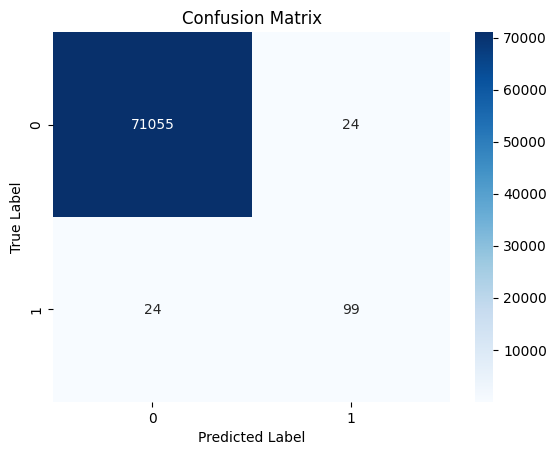

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode

    # Lists to store true and predicted labels
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()  # Convert to binary predictions

            true_labels.extend(labels.numpy())
            predictions.extend(predicted.numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Print metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Plot confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Usage Example
# Assuming you have a test_loader with test data
evaluate_model(model, test_loader)


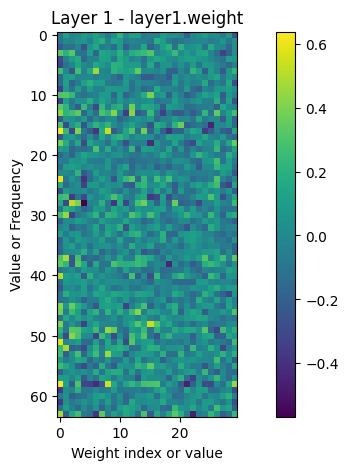

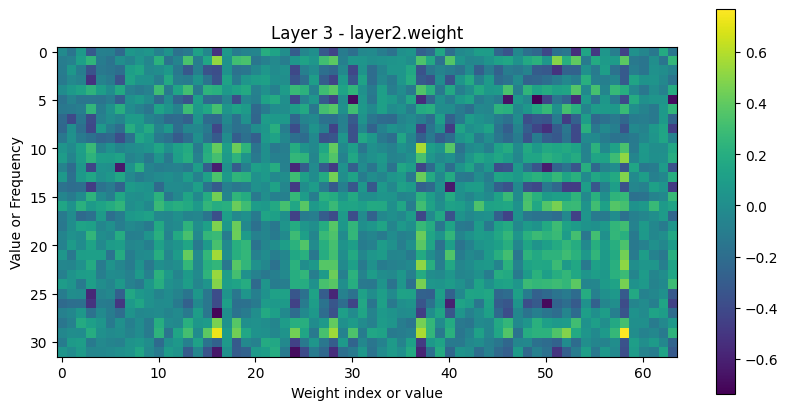

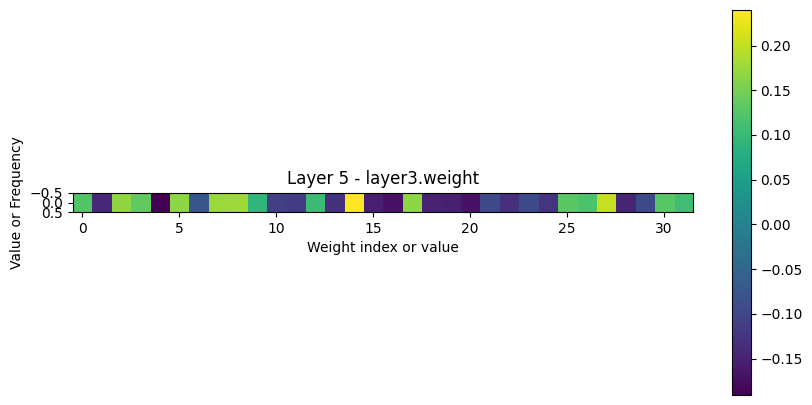

In [8]:
import matplotlib.pyplot as plt
import torch

def visualize_model_weights(model):
    for i, (name, param) in enumerate(model.named_parameters()):
        if 'weight' in name:
            plt.figure(figsize=(10, 5))
            plt.title(f'Layer {i+1} - {name}')
            
            # For weight matrices
            if param.ndim == 2:
                # Heatmap for 2D weight matrices
                plt.imshow(param.data.numpy(), cmap='viridis')
                plt.colorbar()
            
            # For weight vectors
            elif param.ndim == 1:
                # Histogram for 1D weight vectors
                plt.hist(param.data.numpy(), bins=50)
            
            plt.xlabel('Weight index or value')
            plt.ylabel('Value or Frequency')
            plt.show()

# Assuming 'model' is your trained model instance
visualize_model_weights(model)
